# **TP - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema 1 - Sistema de Tráfego**

In [7]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random

### Variaveis Globais

In [8]:
NUM_NODES = 32
MAX_OUT_DEGREE = 2

### Função para gerar digrafo conexo

In [9]:
def graph_generator():
    G = nx.DiGraph()

    nodes = [v for v in range(1,NUM_NODES+1)]
    G.add_nodes_from(nodes)
    random.shuffle(nodes)

    for i in range(len(nodes)-1):
        G.add_edge(nodes[i], nodes[i+1])
    G.add_edge(nodes[len(nodes)-1],nodes[0])

    for n in nodes:
        candidates = [v for v in nodes if v != n]
        random.shuffle(candidates)
        num_adj = random.randint(0,MAX_OUT_DEGREE-1)
        for i in range(num_adj):
            G.add_edge(n, candidates[i])
    return G

### Função para gerar digrafo conexo cirando primeiro um ciclo

In [14]:
def graph_generator_simple():
    G = nx.DiGraph()

    nodes = [n for n in range(1,NUM_NODES+1)]
    choosen = []
    G.add_nodes_from(nodes)
    random.shuffle(nodes)
    
    s = random.choice(nodes)
    nodes.remove(s)
    choosen.append(s)
    d = random.choice(nodes)
    nodes.remove(d)
    choosen.append(d)
    
    G.add_edge(s,d)
    G.add_edge(d,s)
    
    while nodes:
        to_add = random.choice(nodes)
        nodes.remove(to_add)
        s = random.choice(choosen)
        d = random.choice(choosen)
        if G.out_degree(s) == 3 or random.choice([0,1]):
            d = random.choice(list(G.successors(s)))
            G.remove_edge(s,d)
            G.add_edge(s,to_add)
            G.add_edge(to_add,d)
        else:
            G.add_edge(s,to_add)
            G.add_edge(to_add,s)
        choosen.append(to_add)
    
    nodes = [n for n in G.nodes() if G.out_degree(n)<MAX_OUT_DEGREE]
    while nodes:
        s = nodes.pop()
        r = random.randint(0,MAX_OUT_DEGREE - 1 - G.out_degree(s))
        candidates = [n for n in G.nodes() if n != s]
        for i in range(r):
            d = random.choice(candidates)
            candidates.remove(d)
            G.add_edge(s,d)
            
    return G

### Função para gerar subdigrafo conexo minimal

In [21]:
def sub_graph_generator(G):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    A = {}
    
    for edge in G.edges():
        A[edge] = solver.BoolVar('%i%i' %edge)
    
    
    
    nodes = [e for e in G.nodes()]
    s = nodes.pop(0)
    
    P = {}
    
    #garantir que de s conseguimos chegar a todo o d e de todo o d chegamos a s
    
    for d in nodes:
        
        #garantir que ha caminho de s para d
        paths = list(nx.all_simple_edge_paths(G, s, d))
        N = len(paths)
        for i in range(N):
            P[(s,d,i)] = solver.BoolVar('%i%i%i' %(s,d,i))
            for edge in paths[i]:
                solver.Add(P[(s,d,i)] <= A[edge])
        solver.Add(sum([P[(s,d,i)] for i in range(N)])>=1)
        
        #garantir que ha caminho de d para s
        paths = list(nx.all_simple_edge_paths(G, d, s))
        N = len(paths)
        for i in range(N):
            P[(d,s,i)] = solver.BoolVar('%i%i%i' %(d,s,i))
            for edge in paths[i]:
                solver.Add(P[(d,s,i)] <= A[edge])
        solver.Add(sum([P[(d,s,i)] for i in range(N)])>=1)
            
        
    
    solver.Minimize(sum([A[edge] for edge in G.edges]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        S = nx.DiGraph()
        S.add_nodes_from(G.nodes())
        for edge in A:
            if A[edge].solution_value() == 1:
                S.add_edge(edge[0],edge[1])
        return S
    else:
        print("Sem solução")
                
                
    

### Testes

#### Gerar Grafo

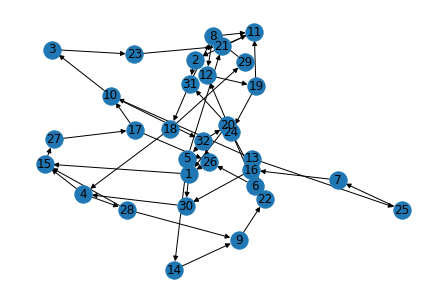

In [10]:
G1 = graph_generator()
nx.draw(G1, with_labels = True)

#### Verificar se é conexo 

In [13]:
nx.is_strongly_connected(G1)

True

#### Gerar Subgrafo minimal

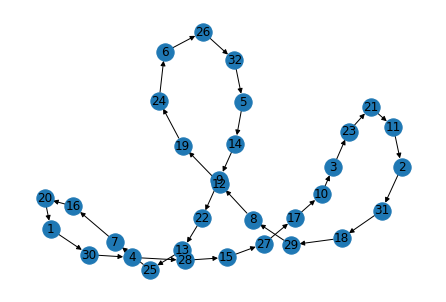

In [30]:
S1 = sub_graph_generator(G1)
nx.draw(S1, with_labels = True)

#### Verificar se é conexo 

In [24]:
nx.is_strongly_connected(S1)

True

#### Nº de arestas removidas

In [25]:
print(len(G1.edges()) - len(S1.edges()))

16


#### Gerar Grafo com a função que cria primeiro um ciclo

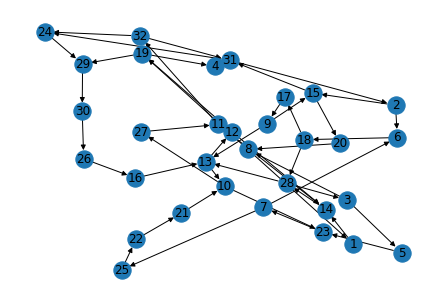

In [15]:
G2 = graph_generator()
nx.draw(G2, with_labels = True)

#### Verificar se é conexo 

In [20]:
nx.is_strongly_connected(G2)

True

#### Gerar Subgrafo minimal

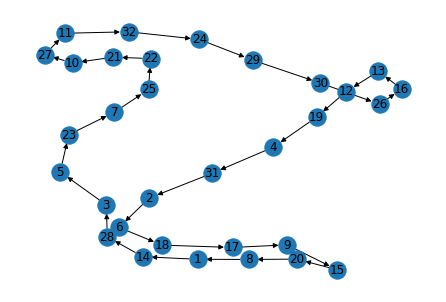

In [26]:
S2 = sub_graph_generator(G2)
nx.draw(S2, with_labels = True)

#### Verificar se é conexo 

In [27]:
nx.is_strongly_connected(S2)

True

#### Nº de arestas removidas

In [28]:
print(len(G2.edges()) - len(S2.edges()))

15
